In [27]:
push!(LOAD_PATH, ".")
using Setup

In [27]:
using Zygote
using CuArrays
using CUDAnative
using CUDAdrv
using NNlib
using Test
using BenchmarkTools
using Flux
using Plots
using Images
using Colors
using ProgressMeter

In [5]:
Zygote.@adjoint gpu(a :: Array) = gpu(a), a̅ -> (cpu(a̅),)
Zygote.refresh()

# cuda stuff

In [37]:
N = 2^20
x = fill(1.0f0, N)  # a vector filled with 1.0 (Float32)
y = fill(2.0f0, N)  # a vector filled with 2.0

y .+= x             # increment each element of y with the corresponding element of x

1048576-element Array{Float32,1}:
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 ⋮  
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0

In [39]:
@test all(y .== 3.0f0)

Test Passed

In [40]:
function sequential_add!(y, x)
    for i in eachindex(y, x)
        @inbounds y[i] += x[i]
    end
    return nothing
end

fill!(y, 2)
sequential_add!(y, x)
@test all(y .== 3.0f0)

Test Passed

In [41]:
function parallel_add!(y, x)
    Threads.@threads for i in eachindex(y, x)
        @inbounds y[i] += x[i]
    end
    return nothing
end

fill!(y, 2)
parallel_add!(y, x)
@test all(y .== 3.0f0)

Test Passed

In [44]:
@btime sequential_add!($y, $x)

  321.687 μs (0 allocations: 0 bytes)


In [45]:
@btime sequential_add!($y, $x)

  326.044 μs (0 allocations: 0 bytes)


In [46]:
x_d = CuArrays.fill(1.0f0, N)  # a vector stored on the GPU filled with 1.0 (Float32)
y_d = CuArrays.fill(2.0f0, N)  # a vector stored on the GPU filled with 2.0

1048576-element CuArray{Float32,1,Nothing}:
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 ⋮  
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0

In [47]:
y_d .+= x_d
@test all(Array(y_d) .== 3.0f0)

Test Passed

In [48]:
function add_broadcast!(y, x)
    CuArrays.@sync y .+= x
    return
end

@btime add_broadcast!(y_d, x_d)

  58.964 μs (63 allocations: 2.67 KiB)


In [49]:
using CUDAnative

function gpu_add1!(y, x)
    for i = 1:length(y)
        @inbounds y[i] += x[i]
    end
    return nothing
end

fill!(y_d, 2)
@cuda gpu_add1!(y_d, x_d)
@test all(Array(y_d) .== 3.0f0)

Test Passed

In [50]:
function bench_gpu1!(y, x)
    CuArrays.@sync begin
        @cuda gpu_add1!(y, x)
    end
end

@btime bench_gpu1!(y_d, x_d)

  149.128 ms (25 allocations: 736 bytes)


In [51]:
using CUDAdrv
bench_gpu1!(y_d, x_d)  # run it once to force compilation
CUDAdrv.@profile bench_gpu1!(y_d, x_d)

┌ Warning: Calling CUDAdrv.@profile only informs an external profiler to start.
│ The user is responsible for launching Julia under a CUDA profiler like `nvprof`.
│ 
│ For improved usability, launch Julia under the Nsight Systems profiler:
│ $ nsys launch -t cuda,cublas,cudnn,nvtx julia
└ @ CUDAdrv.Profile /data/scratch/jhgilles/.julia/packages/CUDAdrv/3EzC1/src/profile.jl:42


In [52]:
function gpu_add2!(y, x)
    index = threadIdx().x    # this example only requires linear indexing, so just use `x`
    stride = blockDim().x
    for i = index:stride:length(y)
        @inbounds y[i] += x[i]
    end
    return nothing
end

fill!(y_d, 2)
@cuda threads=256 gpu_add2!(y_d, x_d)
@test all(Array(y_d) .== 3.0f0)

Test Passed

In [53]:
function bench_gpu2!(y, x)
    CuArrays.@sync begin
        @cuda threads=256 gpu_add2!(y, x)
    end
end

@btime bench_gpu2!(y_d, x_d)

  1.308 ms (25 allocations: 736 bytes)


In [54]:
function gpu_add3!(y, x)
    index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    stride = blockDim().x * gridDim().x
    for i = index:stride:length(y)
        @inbounds y[i] += x[i]
    end
    return nothing
end

numblocks = ceil(Int, N/256)

fill!(y_d, 2)
@cuda threads=256 blocks=numblocks gpu_add3!(y_d, x_d)
@test all(Array(y_d) .== 3.0f0)

Test Passed

In [55]:
function bench_gpu3!(y, x)
    numblocks = ceil(Int, length(y)/256)
    CuArrays.@sync begin
        @cuda threads=256 blocks=numblocks gpu_add3!(y, x)
    end
end

@btime bench_gpu3!(y_d, x_d)

  57.996 μs (28 allocations: 784 bytes)


In [56]:
function gpu_add2_print!(y, x)
    index = threadIdx().x    # this example only requires linear indexing, so just use `x`
    stride = blockDim().x
    @cuprintf("threadIdx %ld, blockDim %ld\n", index, stride)
    for i = index:stride:length(y)
        @inbounds y[i] += x[i]
    end
    return nothing
end

@cuda threads=16 gpu_add2_print!(y_d, x_d)
synchronize()

threadIdx 1, blockDim 16
threadIdx 2, blockDim 16
threadIdx 3, blockDim 16
threadIdx 4, blockDim 16
threadIdx 5, blockDim 16
threadIdx 6, blockDim 16
threadIdx 7, blockDim 16
threadIdx 8, blockDim 16
threadIdx 9, blockDim 16
threadIdx 10, blockDim 16
threadIdx 11, blockDim 16
threadIdx 12, blockDim 16
threadIdx 13, blockDim 16
threadIdx 14, blockDim 16
threadIdx 15, blockDim 16
threadIdx 16, blockDim 16


# quantization

In [ ]:
weightbin(w, 

# MNIST

In [6]:
# Classifies MNIST digits with a convolutional network.
# Writes out saved model to the file "mnist_conv.bson".
# Demonstrates basic model construction, training, saving,
# conditional early-exit, and learning rate scheduling.
#
# This model, while simple, should hit around 99% test
# accuracy after training for approximately 20 epochs.

using Flux, Flux.Data.MNIST, Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle
using Base.Iterators: repeated, partition
using Printf, BSON

# Load labels and images from Flux.Data.MNIST
@info("Loading data set")
train_labels = MNIST.labels()
train_imgs = MNIST.images()
()

┌ Info: Loading data set
└ @ Main In[6]:15


()

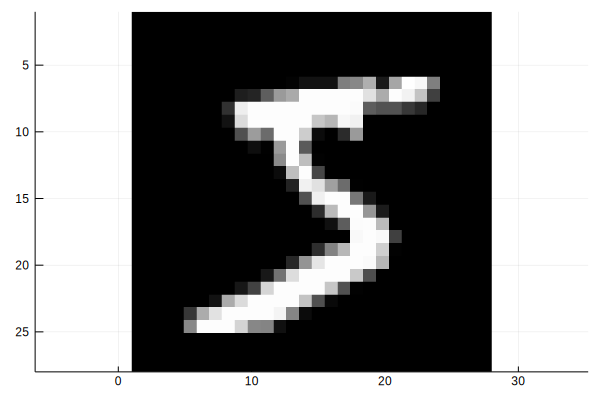

In [7]:
plot(train_imgs[1], aspect_ratio=1)

In [8]:
# Bundle images together with labels and group into minibatchess
function make_minibatch(X, Y, idxs)
    X_batch = Array{Float32}(undef, size(X[1])..., 1, length(idxs))
    for i in 1:length(idxs)
        X_batch[:, :, :, i] = Float32.(X[idxs[i]])
    end
    Y_batch = onehotbatch(Y[idxs], 0:9)
    return (X_batch, Y_batch)
end
batch_size = 128
mb_idxs = partition(1:length(train_imgs), batch_size)
train_set = [make_minibatch(train_imgs, train_labels, i) for i in mb_idxs]

# Prepare test set as one giant minibatch:
test_imgs = MNIST.images(:test)
test_labels = MNIST.labels(:test)
test_set = make_minibatch(test_imgs, test_labels, 1:length(test_imgs))
()

()

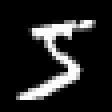

In [9]:
Gray.(train_set[1][1][:,:,1,1])

In [91]:
train_set[1][2][:, 1]

10-element Flux.OneHotVector:
 false
 false
 false
 false
 false
  true
 false
 false
 false
 false

In [10]:
# Define our model.  We will use a simple convolutional architecture with
# three iterations of Conv -> ReLU -> MaxPool, followed by a final Dense
# layer that feeds into a softmax probability output.
@info("Constructing model...")
model = Chain(
    # First convolution, operating upon a 28x28 image
    Conv((3, 3), 1=>16, pad=(1,1), relu),
    MaxPool((2,2)),

    # Second convolution, operating upon a 14x14 image
    Conv((3, 3), 16=>32, pad=(1,1), relu),
    MaxPool((2,2)),

    # Third convolution, operating upon a 7x7 image
    Conv((3, 3), 32=>32, pad=(1,1), relu),
    MaxPool((2,2)),

    # Reshape 3d tensor into a 2d one, at this point it should be (3, 3, 32, N)
    # which is where we get the 288 in the `Dense` layer below:
    x -> reshape(x, :, size(x, 4)),
    Dense(288, 10),

    # Finally, softmax to get nice probabilities
    softmax,
)

┌ Info: Constructing model...
└ @ Main In[10]:4


Chain(Conv((3, 3), 1=>16, NNlib.relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Conv((3, 3), 16=>32, NNlib.relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Conv((3, 3), 32=>32, NNlib.relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), getfield(Main, Symbol("##9#10"))(), Dense(288, 10), NNlib.softmax)

In [11]:
# Load model and datasets onto GPU, if enabled
train_set = gpu.(train_set)
test_set = gpu.(test_set)
model = gpu(model)

Chain(Conv((3, 3), 1=>16, NNlib.relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Conv((3, 3), 16=>32, NNlib.relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Conv((3, 3), 32=>32, NNlib.relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), getfield(Main, Symbol("##9#10"))(), Dense(288, 10), NNlib.softmax)

In [12]:
# `loss()` calculates the crossentropy loss between our prediction `y_hat`
# (calculated from `model(x)`) and the ground truth `y`.  We augment the data
# a bit, adding gaussian random noise to our image to make it more robust.
function loss(x, y)
    # We augment `x` a little bit here, adding in random noise
    #x_aug = x .+ 0.1f0*gpu(randn(eltype(x), size(x)))
    #y_hat = model(x_aug)
    y_hat = model(x)
    return crossentropy(y_hat, y)
end
accuracy(x, y) = mean(onecold(model(x)) .== onecold(y))

accuracy (generic function with 1 method)

In [13]:
# Make sure our model + gradients are nicely precompiled before starting our training loop
model(train_set[1][1])
_ = gradient(Flux.params(model)) do
    loss(train_set[1]...)
end
()

()

In [15]:
@info(".")
# Train our model with the given training set using the ADAM optimizer and
# printing out performance against the test set as we go.
opt = ADAM(0.001)

┌ Info: .
└ @ Main In[15]:1


ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}())

In [28]:
"""
    train!(loss, params, data, opt; cb)
For each datapoint `d` in `data` computes the gradient of `loss(d...)` through
backpropagation and calls the optimizer `opt`.
Takes a callback as keyword argument `cb`. For example, this will print "training"
every 10 seconds:
```julia
Flux.train!(loss, params, data, opt,
            cb = throttle(() -> println("training"), 10))
```
The callback can call `Flux.stop()` to interrupt the training loop.
Multiple optimisers and callbacks can be passed to `opt` and `cb` as arrays.
"""
function train!(loss, ps, data, opt; cb = () -> ())
  ps = Params(ps)
  cb = runall(cb)
  @showprogress for d in data
    try
      gs = gradient(ps) do
        loss(d...)
      end
      update!(opt, ps, gs)
      cb()
    catch ex
      if ex isa StopException
        break
      else
        rethrow(ex)
      end
    end
  end
end

train!

In [30]:
@info("Beginning training loop...")

best_acc = 0.0
last_improvement = 0

for epoch_idx in 1:1 # 1:100
    global best_acc, last_improvement
    # Train for a single epoch
    train!(loss, Flux.params(model), train_set, opt)

    # Calculate accuracy:
    acc = accuracy(test_set...)
    @info(@sprintf("[%d]: Test accuracy: %.4f", epoch_idx, acc))

    # If our accuracy is good enough, quit out.
    if acc >= 0.999
        @info(" -> Early-exiting: We reached our target accuracy of 99.9%")
        break
    end

    # If this is the best accuracy we've seen so far, save the model out
    if acc >= best_acc
        @info(" -> New best accuracy! Saving model out to mnist_conv.bson")
        BSON.@save joinpath(dirname(@__FILE__), "mnist_conv.bson") model epoch_idx acc
        best_acc = acc
        last_improvement = epoch_idx
    end

    # If we haven't seen improvement in 5 epochs, drop our learning rate:
    if epoch_idx - last_improvement >= 5 && opt.eta > 1e-6
        opt.eta /= 10.0
        @warn(" -> Haven't improved in a while, dropping learning rate to $(opt.eta)!")

        # After dropping learning rate, give it a few epochs to improve
        last_improvement = epoch_idx
    end

    if epoch_idx - last_improvement >= 10
        @warn(" -> We're calling this converged.")
        break
    end
end

┌ Info: Beginning training loop...
└ @ Main In[30]:1


InterruptException: InterruptException: